# TALENT ACQUISITION ANALYTICS (Recruitment Analytics)

## Introduction

This notebook provides a walkthrough for calculating key HR metrics and KPIs related to talent acquisition using Python. It is part of the **“HR Analytics with Python”** series, where the aim is to elaborate on math and calculations of HR metrics. I also aim to cover all major HR domains—including recruitment, training, retention, and performance—through practical, code-driven examples.

The purpose is to demonstrate how recruitment and hiring data can be analyzed to uncover workforce trends, evaluate recruitment effectiveness, and support data-driven decision making.

In this notebook, I will:

* Calculate essential talent acquisition metrics such as vacancy rate, time-to-fill, quality of hire, and hire trends. It is note that descriptive analysis is a must, but I skip it here.
* Provide step-by-step explanations of the formulas, logic, and methodology used for each metric.
* Showcase practical Python implementations for data processing, analysis, and interactive visualization.

The goal is to give a clear, reproducible example of how HR data can be transformed into actionable insights, helping organizations optimize their recruitment strategies and workforce planning.

##### **Important Notes**

**These HR metrics formula may require customization for each organization.**
If you decide to apply any metrics shown in this notebook, validate all metric definitions with your c-suits, HR, and key stakeholders


### Table of Contents 
- [Datasets](#Datasets) 
- [Talent Acquisition Analytics](#talent-acquisition-analytics) 
    - [Vacancy Rate](#vacancy-rate) 
    - [Time-to-Fill](#time-to-fill) 
    - [Quality of Hire](#quality-of-hire) 
    - [Hire Trend Analysis](#hire-trend-analysis)
        - [Previous Job Title (Using NLP)](#previous-job-title-using-nlp)
        - [Applicant by Country](#applicant-by-country)
        - [Experience and Salary by Age Group](#experience-and-salary-by-age-group)

## Datasets

The dataset used here is the cleaned version of the raw HR data. Initial exploratory data analysis (EDA) and basic data wrangling steps (such as handling missing values, standardizing fields, and correcting data types) were already performed in Notebook 00.

In [15]:
# Libraries and datasets

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

data_files = {
    "employee_df": "data/cleaned_employee_data.csv",
    "recruit_df": "data/cleaned_recruitment_data.csv",
}

def load_datasets(file_dict):
    datasets = {}
    for key, file_path in file_dict.items():
        datasets[key] = pd.read_csv(file_path)
    return datasets

datasets = load_datasets(data_files)

employee_df = datasets["employee_df"]
recruit_df = datasets["recruit_df"]

In [16]:
#  Function to parse date columns 
def parse_date_columns(df, date_columns, fill_na_with_now=False):
    
    df = df.copy()
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    return df

# Employee data
employee_date_cols = ['DOB', 'StartDate', 'ExitDate']
employee_df = parse_date_columns(employee_df, employee_date_cols, fill_na_with_now=True)

# Applicant data
recruit_df_cols = ['ApplicationDate', 'DateofBirth']
recruit_df = parse_date_columns(recruit_df, recruit_df_cols)


In [17]:
employee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   EmpID                  3000 non-null   int64         
 1   FirstName              3000 non-null   object        
 2   LastName               3000 non-null   object        
 3   StartDate              3000 non-null   datetime64[ns]
 4   ExitDate               1533 non-null   datetime64[ns]
 5   Title                  3000 non-null   object        
 6   Supervisor             3000 non-null   object        
 7   ADEmail                3000 non-null   object        
 8   BusinessUnit           3000 non-null   object        
 9   EmployeeType           3000 non-null   object        
 10  PayZone                3000 non-null   object        
 11  TerminationType        1533 non-null   object        
 12  DepartmentType         3000 non-null   object        
 13  Div

In [18]:
recruit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ApplicantID        3000 non-null   int64         
 1   ApplicationDate    3000 non-null   datetime64[ns]
 2   FirstName          3000 non-null   object        
 3   LastName           3000 non-null   object        
 4   Gender             3000 non-null   object        
 5   DateofBirth        3000 non-null   datetime64[ns]
 6   PhoneNumber        2600 non-null   object        
 7   Email              3000 non-null   object        
 8   Address            3000 non-null   object        
 9   City               3000 non-null   object        
 10  State              3000 non-null   object        
 11  ZipCode            3000 non-null   int64         
 12  Country            2743 non-null   object        
 13  EducationLevel     3000 non-null   object        
 14  YearsofE

===============================================================================

## Talent Acquisition

In [19]:
# Copy dataframe
talent_acq_df = employee_df.copy()


### Vacancy Rate

**Vacancy rate** shows how much time job positions spend unfilled compared to the total time they could have been filled. It helps HR understand workforce gaps and highlights roles that may take longer to staff.

$$
\text{Vacancy Rate (\%)} = \frac{\text{Number of vacant days in a period}}{\text{Total possible days for the position in the same period}} \times 100
$$

* Number of vacant days in a period: the total number of days a position was open but not filled in a specific period.
* Total possible days: the number of days the position was expected to exist in that same period (from when the role was first observed until the last exit date or the end of the year).

**A higher vacancy rate** means roles are left open for longer, which may signal hiring challenges or inefficiencies in recruitment.

In the code, I first divide each employee’s employment period into months and calculate how many days they were actually active in each month. For each position, I find the total possible days it could have been filled by multiplying the fixed headcount by the number of days in that month. The vacant days are then the difference between total possible days and the days the position was filled.

Finally, I calculate the vacancy rate as the percentage of vacant days over total possible days and aggregate it by year, division, and job position. I use a heatmap to visualize vacancy rates across positions and years. Darker colors show higher vacancy rates.

In [20]:
# First fill the missing ExitDate with the end of the year date (for active employees)
talent_acq_df["ExitDate"] = talent_acq_df["ExitDate"].fillna(pd.Timestamp("2025-12-31"))
talent_acq_df["ExitDate"].head()

0   2025-12-31
1   2025-12-31
2   2025-12-31
3   2025-12-31
4   2025-12-31
Name: ExitDate, dtype: datetime64[ns]

In [21]:
"""
Each employee’s employment is divided into monthly periods.
For each month, calculate the days the employee was actually active and the total days in that period (actually days in month)
"""

# Create empty list to store records
all_records = []

# Loop through each employee
for _, row in talent_acq_df.iterrows():
    
    # Split employment into monthly periods (output: year-month)
    start_employement_ym = row.StartDate.to_period("M")
    end_employement_ym = row.ExitDate.to_period("M")

    # Loop through each month in the range
    for month_interval in pd.period_range(start_employement_ym, end_employement_ym, freq="M"):
        
        # Start and end of the actual calendar month
        month_start =  month_interval.start_time
        month_end =  month_interval.end_time
        
        # Find the actual overlap of employment with this period
        # row.StartDate and row.ExitDate are employee’s actual employment dates
        overlap_start = max(row.StartDate, month_start)
        overlap_end = min(row.ExitDate, month_end)

        # Count number of days that the employee was active in this period
        active_days = (overlap_end - overlap_start).days + 1
        
        # Get actual number of days in the month
        days_in_period = (month_end - month_start).days + 1

        # Store the record
        all_records.append({
            "EmployeeID": row.EmpID,
            "BusinessUnit": row.BusinessUnit,
            "Division": row.Division,
            "JobPosition": row.Title,
            "MonthInterval": month_interval, 
            "PeriodStartDate": month_start,
            "PeriodEndDate": month_end,
            "EmployeeStartDate": row.StartDate,
            "EmployeeExitDate": row.ExitDate,
            "OverlapStart": overlap_start,
            "OverlapEnd": overlap_end,
            "ActiveDays": active_days,
            "DaysInPeriod": days_in_period
        })

# Convert all records into a DataFrame
vacancy_df = pd.DataFrame(all_records)
vacancy_df.head()

,EmployeeID,BusinessUnit,Division,JobPosition,MonthInterval,PeriodStartDate,PeriodEndDate,EmployeeStartDate,EmployeeExitDate,OverlapStart,OverlapEnd,ActiveDays,DaysInPeriod
0,3427,CCDR,Finance & Accounting,Production Technician I,2019-09,2019-09-01,2019-09-30 23:59:59.999999999,2019-09-20,2025-12-31,2019-09-20,2019-09-30 23:59:59.999999999,11,30
1,3427,CCDR,Finance & Accounting,Production Technician I,2019-10,2019-10-01,2019-10-31 23:59:59.999999999,2019-09-20,2025-12-31,2019-10-01,2019-10-31 23:59:59.999999999,31,31
2,3427,CCDR,Finance & Accounting,Production Technician I,2019-11,2019-11-01,2019-11-30 23:59:59.999999999,2019-09-20,2025-12-31,2019-11-01,2019-11-30 23:59:59.999999999,30,30
3,3427,CCDR,Finance & Accounting,Production Technician I,2019-12,2019-12-01,2019-12-31 23:59:59.999999999,2019-09-20,2025-12-31,2019-12-01,2019-12-31 23:59:59.999999999,31,31
4,3427,CCDR,Finance & Accounting,Production Technician I,2020-01,2020-01-01,2020-01-31 23:59:59.999999999,2019-09-20,2025-12-31,2020-01-01,2020-01-31 23:59:59.999999999,31,31


In [22]:
# Compute Filled Days per BU, Division, JobPosition, MonthInterval
filled_days = vacancy_df.groupby(["BusinessUnit", "Division", "JobPosition", "MonthInterval"]).agg(
    ActualFilledDays=("ActiveDays", "sum"),
    DaysInPeriod=("DaysInPeriod", "max") # same for all employees in period
).reset_index()

filled_days

,BusinessUnit,Division,JobPosition,MonthInterval,ActualFilledDays,DaysInPeriod
0,BPC,Aerial,Area Sales Manager,2019-10,30,31
1,BPC,Aerial,Area Sales Manager,2019-11,30,30
2,BPC,Aerial,Area Sales Manager,2019-12,31,31
3,BPC,Aerial,Area Sales Manager,2020-01,31,31
4,BPC,Aerial,Area Sales Manager,2020-02,29,29
...,...,...,...,...,...,...
54573,WBL,Yard (Material Handling),Production Technician I,2025-08,31,31
54574,WBL,Yard (Material Handling),Production Technician I,2025-09,30,30
54575,WBL,Yard (Material Handling),Production Technician I,2025-10,31,31
54576,WBL,Yard (Material Handling),Production Technician I,2025-11,30,30


In [23]:
# As we do not have company headcount in each division, 
# we use maximum number of active employees in each period as proxy for headcount 

headcount = vacancy_df.groupby(["BusinessUnit", "Division", "JobPosition", "MonthInterval"]).size().reset_index(name="Headcount")
headcount

,BusinessUnit,Division,JobPosition,MonthInterval,Headcount
0,BPC,Aerial,Area Sales Manager,2019-10,1
1,BPC,Aerial,Area Sales Manager,2019-11,1
2,BPC,Aerial,Area Sales Manager,2019-12,1
3,BPC,Aerial,Area Sales Manager,2020-01,1
4,BPC,Aerial,Area Sales Manager,2020-02,1
...,...,...,...,...,...
54573,WBL,Yard (Material Handling),Production Technician I,2025-08,1
54574,WBL,Yard (Material Handling),Production Technician I,2025-09,1
54575,WBL,Yard (Material Handling),Production Technician I,2025-10,1
54576,WBL,Yard (Material Handling),Production Technician I,2025-11,1


In [24]:
# Fixed Headcount = max observed headcount per group 
# Now, we have fix headcount for each position in each division and business unit
fixed = headcount.groupby(["BusinessUnit", "Division", "JobPosition"])['Headcount'].max().reset_index(name="FixedHeadcount")
fixed

,BusinessUnit,Division,JobPosition,FixedHeadcount
0,BPC,Aerial,Area Sales Manager,1
1,BPC,Aerial,BI Developer,1
2,BPC,Aerial,IT Manager - Support,1
3,BPC,Aerial,Production Technician I,7
4,BPC,Aerial,Production Technician II,3
...,...,...,...,...
1076,WBL,Wireline Construction,CIO,1
1077,WBL,Wireline Construction,Network Engineer,1
1078,WBL,Wireline Construction,Production Technician I,5
1079,WBL,Wireline Construction,Production Technician II,2


In [25]:
# We can visualize the fixed headcount using a heatmap

# First pivot data
fixed_headcount_hm = fixed.pivot_table(
    index='Division', 
    columns='JobPosition', 
    values='FixedHeadcount', 
    fill_value=0  # fill empty cells with 0
)
fixed_headcount_hm

JobPosition,Accountant I,Administrative Assistant,Area Sales Manager,BI Developer,BI Director,CIO,Data Analyst,Data Architect,Database Administrator,Director of Operations,...,Production Technician I,Production Technician II,Sales Manager,Senior BI Developer,Shared Services Manager,Software Engineer,Software Engineering Manager,Sr. Accountant,Sr. DBA,Sr. Network Engineer
Division,,,,,,,,,,,,,,,,,,,,,
Aerial,1.000000,1.500000,1.750000,1.200000,1.0,1.0,1.00,0.0,1.0,0.000000,...,6.800000,2.300000,1.500000,1.0,0.0,1.000000,0.0,1.0,1.0,1.250000
Billable Consultants,0.000000,1.000000,1.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,...,1.500000,1.400000,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000
Catv,0.000000,1.000000,1.166667,0.000000,0.0,0.0,1.00,1.0,1.0,0.000000,...,2.200000,1.500000,1.000000,1.0,1.0,1.000000,0.0,0.0,0.0,1.000000
Corp Operations,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
Engineers,1.000000,1.000000,1.900000,1.500000,1.0,1.0,1.00,0.0,1.0,0.000000,...,8.400000,3.500000,1.333333,1.5,0.0,1.571429,1.0,0.0,1.0,1.000000
Executive,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.00,0.0,0.0,1.000000,...,1.888889,1.000000,0.000000,1.0,0.0,1.000000,0.0,0.0,0.0,1.500000
Field Operations,2.666667,1.600000,4.900000,1.857143,1.5,1.5,1.75,1.0,1.0,1.333333,...,23.100000,10.200000,2.000000,1.2,1.0,2.200000,2.0,2.0,1.0,1.200000
Fielders,1.000000,0.000000,1.571429,0.000000,0.0,0.0,1.00,0.0,1.0,0.000000,...,2.500000,1.666667,0.000000,0.0,2.0,1.000000,0.0,0.0,0.0,1.000000
Finance & Accounting,1.000000,1.000000,1.333333,1.000000,1.0,0.0,2.00,0.0,0.0,0.000000,...,2.800000,1.200000,1.000000,1.0,0.0,1.000000,1.0,0.0,0.0,0.000000


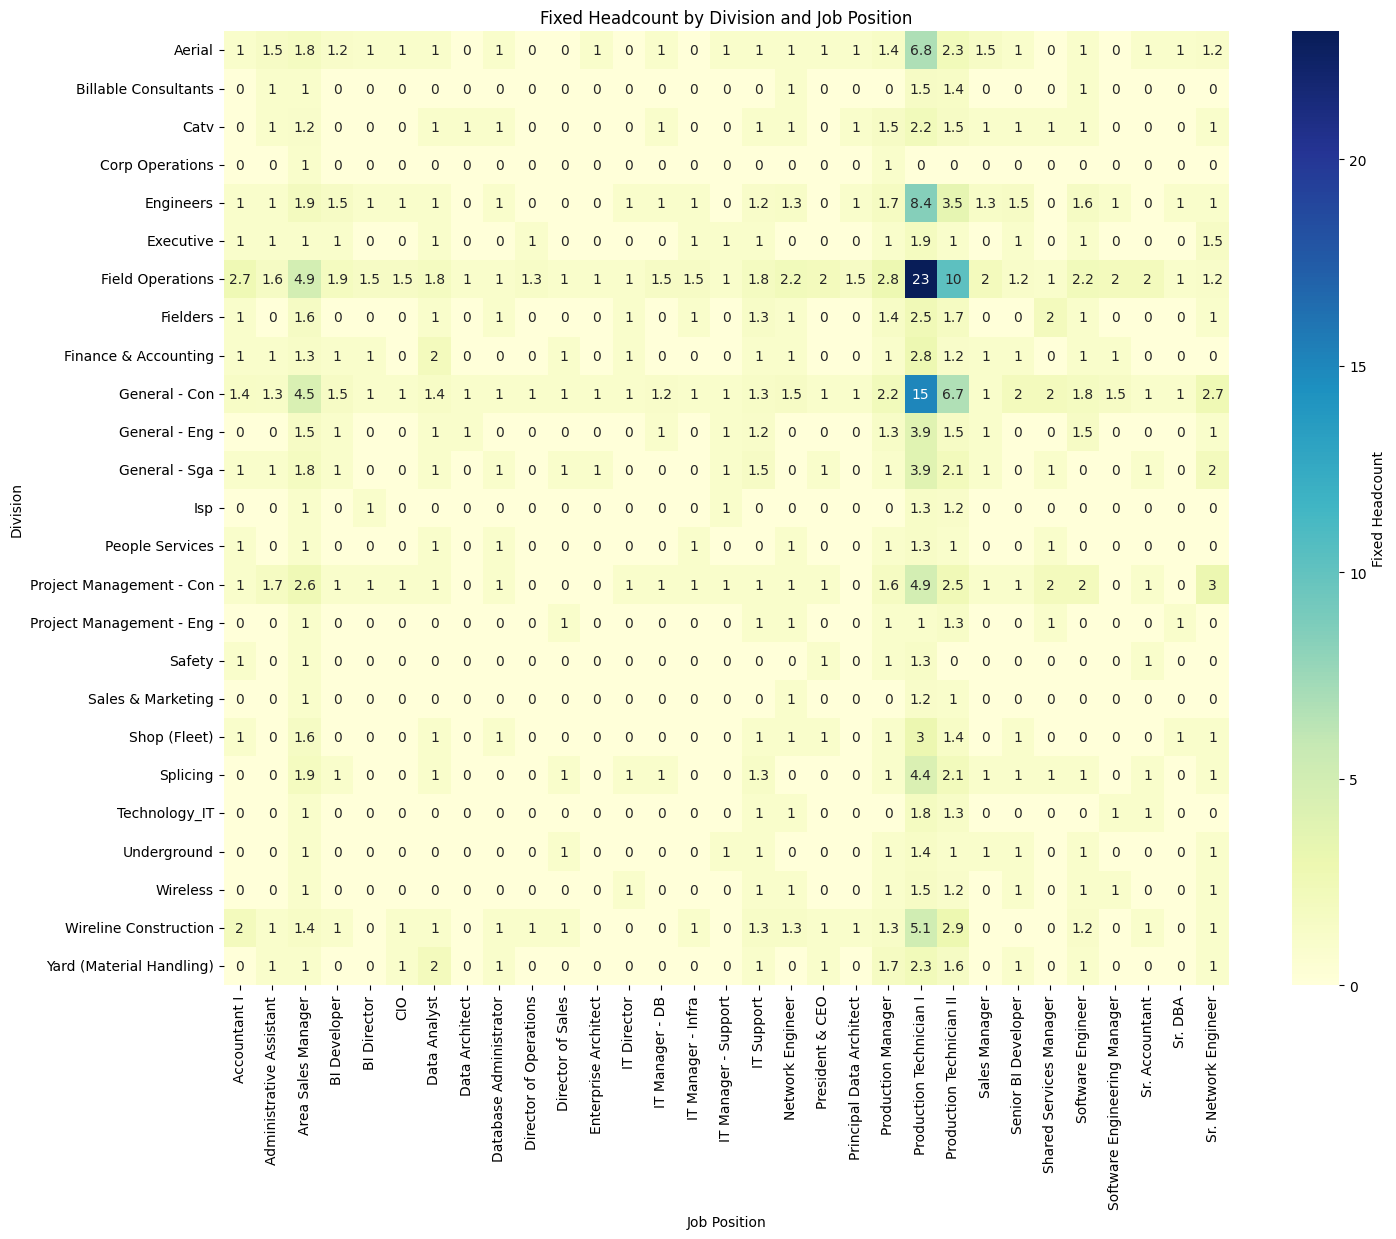

In [26]:
"""
Now, we can see that 'Field Operation' division has high headcount for 'Production Technician 1' position.
"""

# Plot using heatmap
plt.figure(figsize=(15, len(fixed_headcount_hm)*0.5))
sns.heatmap(
    fixed_headcount_hm, 
    annot=True,           
    cmap="YlGnBu", 
    cbar_kws={'label': 'Fixed Headcount'}
)
plt.title('Fixed Headcount by Division and Job Position')
plt.xlabel('Job Position')
plt.ylabel('Division')
plt.tight_layout()
plt.show()


In [27]:
# Now, merge fixed headcount back to filled_days
filled_days = filled_days.merge(fixed, on=["BusinessUnit", "Division", "JobPosition"], how="left")
filled_days

,BusinessUnit,Division,JobPosition,MonthInterval,ActualFilledDays,DaysInPeriod,FixedHeadcount
0,BPC,Aerial,Area Sales Manager,2019-10,30,31,1
1,BPC,Aerial,Area Sales Manager,2019-11,30,30,1
2,BPC,Aerial,Area Sales Manager,2019-12,31,31,1
3,BPC,Aerial,Area Sales Manager,2020-01,31,31,1
4,BPC,Aerial,Area Sales Manager,2020-02,29,29,1
...,...,...,...,...,...,...,...
54573,WBL,Yard (Material Handling),Production Technician I,2025-08,31,31,1
54574,WBL,Yard (Material Handling),Production Technician I,2025-09,30,30,1
54575,WBL,Yard (Material Handling),Production Technician I,2025-10,31,31,1
54576,WBL,Yard (Material Handling),Production Technician I,2025-11,30,30,1


In [28]:
# Compute Vacancy Rate
filled_days["TotalPossibleDaysWithFullyFilled"] = filled_days["FixedHeadcount"] * filled_days["DaysInPeriod"]

filled_days["VacantDays"] = filled_days["TotalPossibleDaysWithFullyFilled"] - filled_days["ActualFilledDays"]

filled_days["VacancyRatePct"] = (filled_days["VacantDays"] / filled_days["TotalPossibleDaysWithFullyFilled"]) * 100
filled_days

,BusinessUnit,Division,JobPosition,MonthInterval,ActualFilledDays,DaysInPeriod,FixedHeadcount,TotalPossibleDaysWithFullyFilled,VacantDays,VacancyRatePct
0,BPC,Aerial,Area Sales Manager,2019-10,30,31,1,31,1,3.225806
1,BPC,Aerial,Area Sales Manager,2019-11,30,30,1,30,0,0.000000
2,BPC,Aerial,Area Sales Manager,2019-12,31,31,1,31,0,0.000000
3,BPC,Aerial,Area Sales Manager,2020-01,31,31,1,31,0,0.000000
4,BPC,Aerial,Area Sales Manager,2020-02,29,29,1,29,0,0.000000
...,...,...,...,...,...,...,...,...,...,...
54573,WBL,Yard (Material Handling),Production Technician I,2025-08,31,31,1,31,0,0.000000
54574,WBL,Yard (Material Handling),Production Technician I,2025-09,30,30,1,30,0,0.000000
54575,WBL,Yard (Material Handling),Production Technician I,2025-10,31,31,1,31,0,0.000000
54576,WBL,Yard (Material Handling),Production Technician I,2025-11,30,30,1,30,0,0.000000


In [29]:
# --- 5. Yearly Aggregation ---
filled_days["Year"] = filled_days["MonthInterval"].dt.year
yearly_vacancy = filled_days.groupby(["BusinessUnit", "Division", "JobPosition", "Year"]).agg(
    VacancyRatePct=("VacancyRatePct", "mean")
).reset_index()

yearly_vacancy

,BusinessUnit,Division,JobPosition,Year,VacancyRatePct
0,BPC,Aerial,Area Sales Manager,2019,1.075269
1,BPC,Aerial,Area Sales Manager,2020,0.000000
2,BPC,Aerial,Area Sales Manager,2021,0.000000
3,BPC,Aerial,Area Sales Manager,2022,0.000000
4,BPC,Aerial,Area Sales Manager,2023,0.000000
...,...,...,...,...,...
5316,WBL,Yard (Material Handling),Production Technician I,2021,0.000000
5317,WBL,Yard (Material Handling),Production Technician I,2022,0.000000
5318,WBL,Yard (Material Handling),Production Technician I,2023,0.000000
5319,WBL,Yard (Material Handling),Production Technician I,2024,0.000000


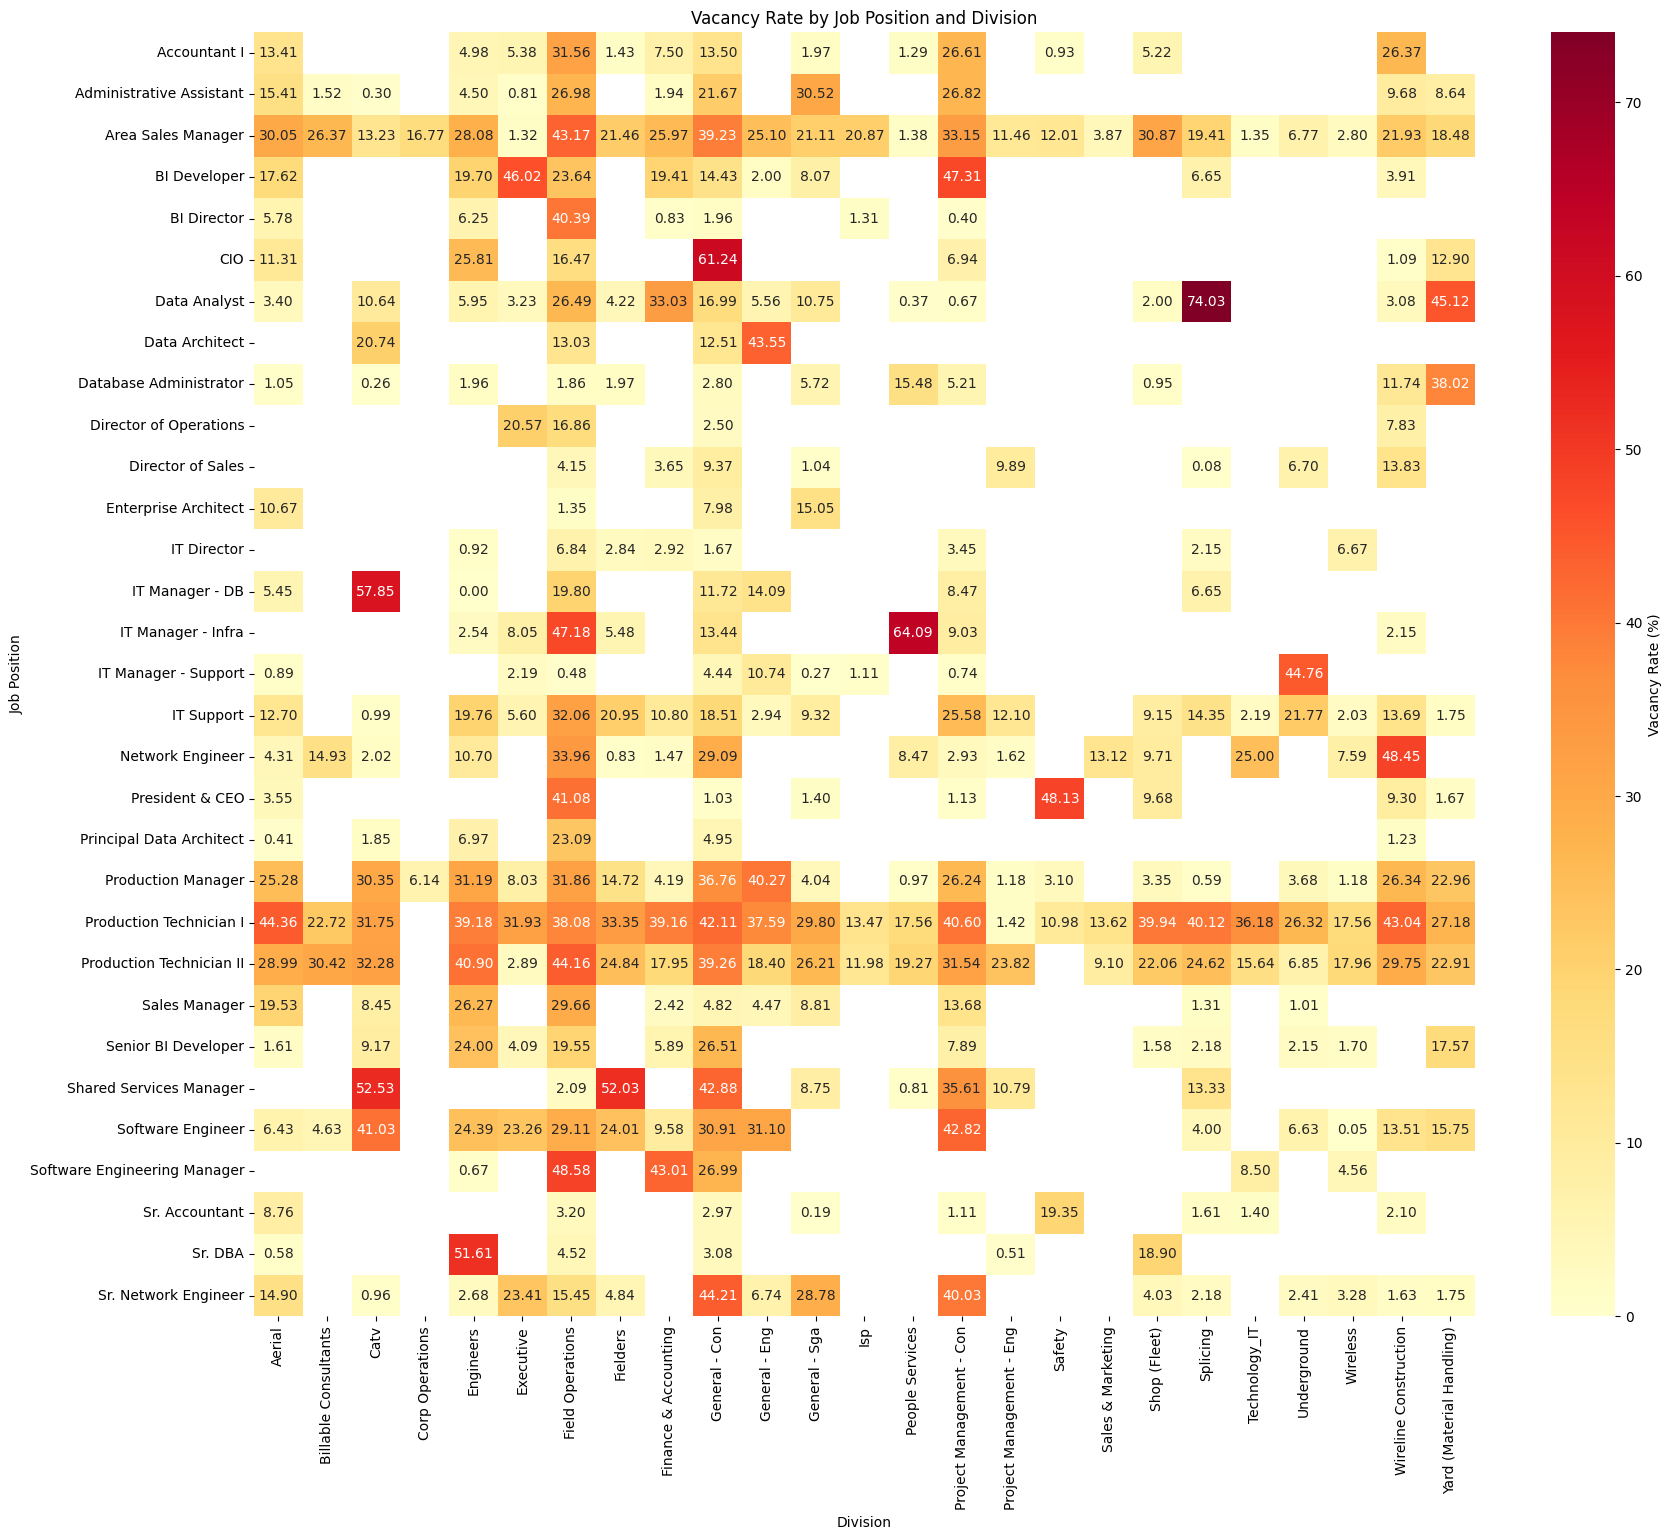

In [30]:
"""
We can visualize overall vacancy rate by job position and division using a heatmap.
"""

# Pivot data
job_vacancy_hm = yearly_vacancy.pivot_table(
    index="JobPosition", 
    columns="Division", 
    values="VacancyRatePct", 
    aggfunc="mean"
)

# heatmap
plt.figure(figsize=(18, len(job_vacancy_hm)*0.5))
sns.heatmap(
    job_vacancy_hm, 
    annot=True,         
    fmt=".2f",           
    cmap="YlOrRd",     
    cbar_kws={'label': 'Vacancy Rate (%)'}
)

plt.title("Vacancy Rate by Job Position and Division")
plt.ylabel("Job Position")
plt.xlabel("Division")
plt.tight_layout()
plt.show()


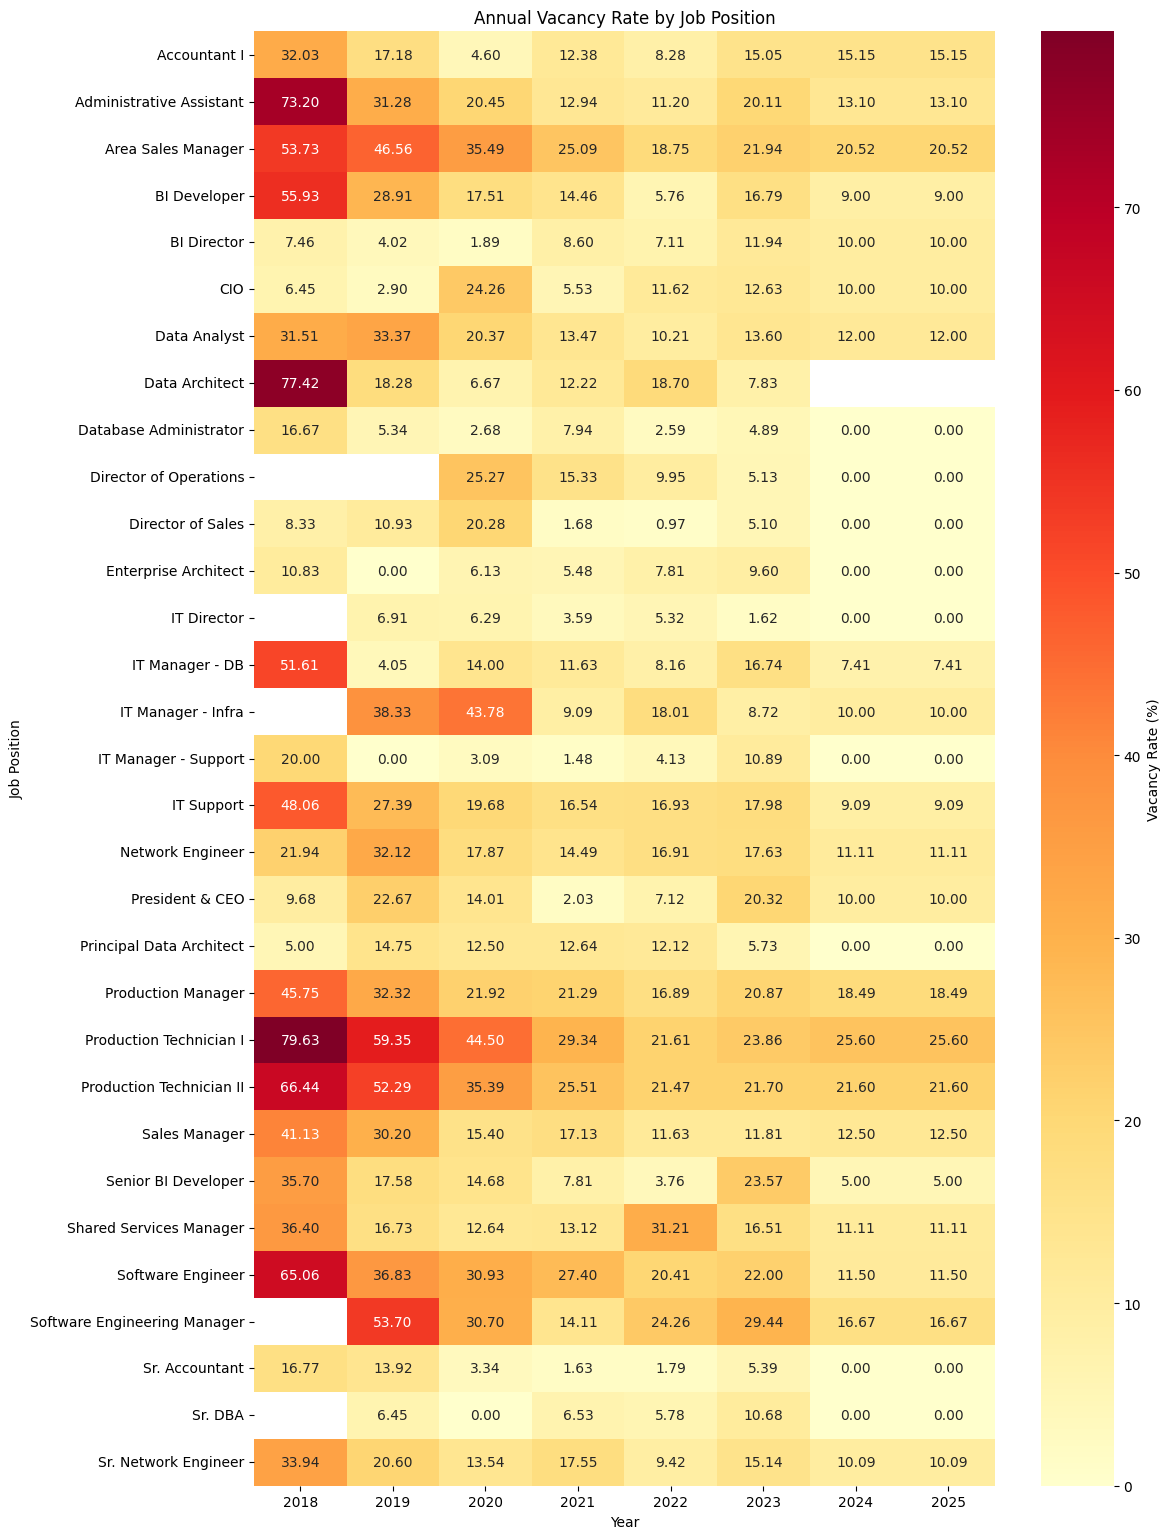

In [31]:
"""
Normally, we might want time-based analysis. SO, we can visualize annual vacancy rate by job position as well.
"""

# Pivot data
yearly_vacancy_hm = yearly_vacancy.pivot_table(
    index="JobPosition", 
    columns="Year", 
    values="VacancyRatePct", 
    aggfunc="mean"
)

# heatmap
plt.figure(figsize=(12, len(yearly_vacancy_hm)*0.5))
sns.heatmap(
    yearly_vacancy_hm, 
    annot=True,         
    fmt=".2f",           
    cmap="YlOrRd",     
    cbar_kws={'label': 'Vacancy Rate (%)'}
)

plt.title("Annual Vacancy Rate by Job Position")
plt.ylabel("Job Position")
plt.xlabel("Year")
plt.tight_layout()
plt.show()


===============================================================================

### Time to Fill

**Time to Fill** measures how many days a position stays vacant before a new employee joins. It reflects the efficiency of the hiring process and helps identify roles that take longer to recruit for.

$$
Time to Fill (Days) = Start Date of New Hire - Exit Date of Previous Employee
$$

* Start Date of New Hire: the date the new employee joins the organization.
* Exit Date of Previous Employee: the date the prior employee leaves the position.

A longer Time to Fill indicates that positions remain vacant for extended periods, which can impact productivity, team workload, and business performance.

In this calculation, only gaps between consecutive employees are considered, and days are counted within the same year for accurate yearly reporting.

Regarding Vacancy Rate, while Time to Fill shows the number of days it takes to hire, the Vacancy Rate reflects how much of the year a position remains unfilled. Longer Time to Fill will usually drive higher Vacancy Rates, but frequent turnover can also keep the vacancy rate high even if time to fill is short. Looking at both together gives a complete picture of workforce gaps and recruitment efficiency.

I proceeded to visualize the Time to Fill data as I had calculated number of days that the position is vacant in the previous step. 

In [32]:
# First, we need to sort data by Division, Title, and StartDate. 
# So that same position in the same division are together and sorted by start date

talent_acq_df = talent_acq_df.sort_values(['Division', 'Title', 'StartDate'])
talent_acq_df.head()

,EmpID,FirstName,LastName,StartDate,ExitDate,Title,Supervisor,ADEmail,BusinessUnit,EmployeeType,...,DOB,State,GenderCode,LocationCode,RaceDesc,MaritalDesc,PerformanceScore,CurrentEmployeeRating,ExitYear,CleanedEmployeeStatus
915,1342,Jeffery,Hogan,2019-06-22,2019-08-26,Accountant I,Mark Willis,jeffery.hogan@bilearner.com,EW,Full-Time,...,1985-06-30,MA,Female,2559,Asian,Single,Fully Meets,3,2019.0,Inactive
945,1372,Frankie,Davenport,2022-11-24,2025-12-31,Accountant I,Gary Clark,frankie.davenport@bilearner.com,MSC,Contract,...,1991-08-19,MA,Male,34610,White,Single,Exceeds,3,NaN,Active
2173,2600,Thomas,Sloan,2018-09-18,2025-12-31,Administrative Assistant,Kelsey Dunn,thomas.sloan@bilearner.com,CCDR,Full-Time,...,1965-01-16,WA,Female,46029,Asian,Widowed,Fully Meets,2,NaN,Active
942,1369,Shea,Novak,2021-03-26,2025-12-31,Administrative Assistant,Darren Zimmerman,shea.novak@bilearner.com,CCDR,Contract,...,1974-03-24,MA,Female,6564,Black,Married,Exceeds,3,NaN,Active
896,1323,Leigh Ann,Smith,2022-12-06,2025-12-31,Administrative Assistant,Mary Walker,leigh ann.smith@bilearner.com,PL,Full-Time,...,1953-03-19,MA,Female,1844,Black,Divorced,Fully Meets,3,NaN,Active


In [33]:
# Fill empty exit dates for active employees with a future date
talent_acq_df['ExitDate'] = talent_acq_df['ExitDate'].fillna(pd.Timestamp('2025-12-31'))

In [34]:
# Extract year of hire from StartDate
talent_acq_df['Year'] = talent_acq_df['StartDate'].dt.year

# Create new column for previous exit date within the same division and title
talent_acq_df['PrevExit'] = talent_acq_df.groupby(['Division', 'Title'])['ExitDate'].shift(1)

# Calculate Time-to-Fill in days
talent_acq_df['TimeToFillDays'] = (talent_acq_df['StartDate'] - talent_acq_df['PrevExit']).dt.days

# Keep only valid positive Time-to-Fill values
talent_acq_df_valid = talent_acq_df[talent_acq_df['TimeToFillDays'] >= 0]

# Cap Time-to-Fill at 365 days per position per year
talent_acq_df_valid['TimeToFillCapped'] = talent_acq_df_valid.groupby(['Division', 'Title', 'Year'])['TimeToFillDays'] \
                                                        .transform(lambda x: x.clip(upper=365))

# Group by department/division, position, and year, and take average Time-to-Fill (capped)
time_to_fill_summary = talent_acq_df_valid.groupby(['Division', 'Title', 'Year'])['TimeToFillCapped'] \
                                        .mean().reset_index()

# Round
time_to_fill_summary['TimeToFillCapped'] = time_to_fill_summary['TimeToFillCapped'].round()
time_to_fill_summary


,Division,Title,Year,TimeToFillCapped
0,Aerial,Accountant I,2022,365.0
1,Aerial,Area Sales Manager,2021,18.0
2,Aerial,Area Sales Manager,2023,93.0
3,Aerial,BI Developer,2022,19.0
4,Aerial,BI Director,2023,365.0
...,...,...,...,...
125,Wireline Construction,Software Engineer,2023,17.0
126,Wireline Construction,Sr. Network Engineer,2023,354.0
127,Yard (Material Handling),Area Sales Manager,2023,365.0
128,Yard (Material Handling),Production Manager,2020,31.0


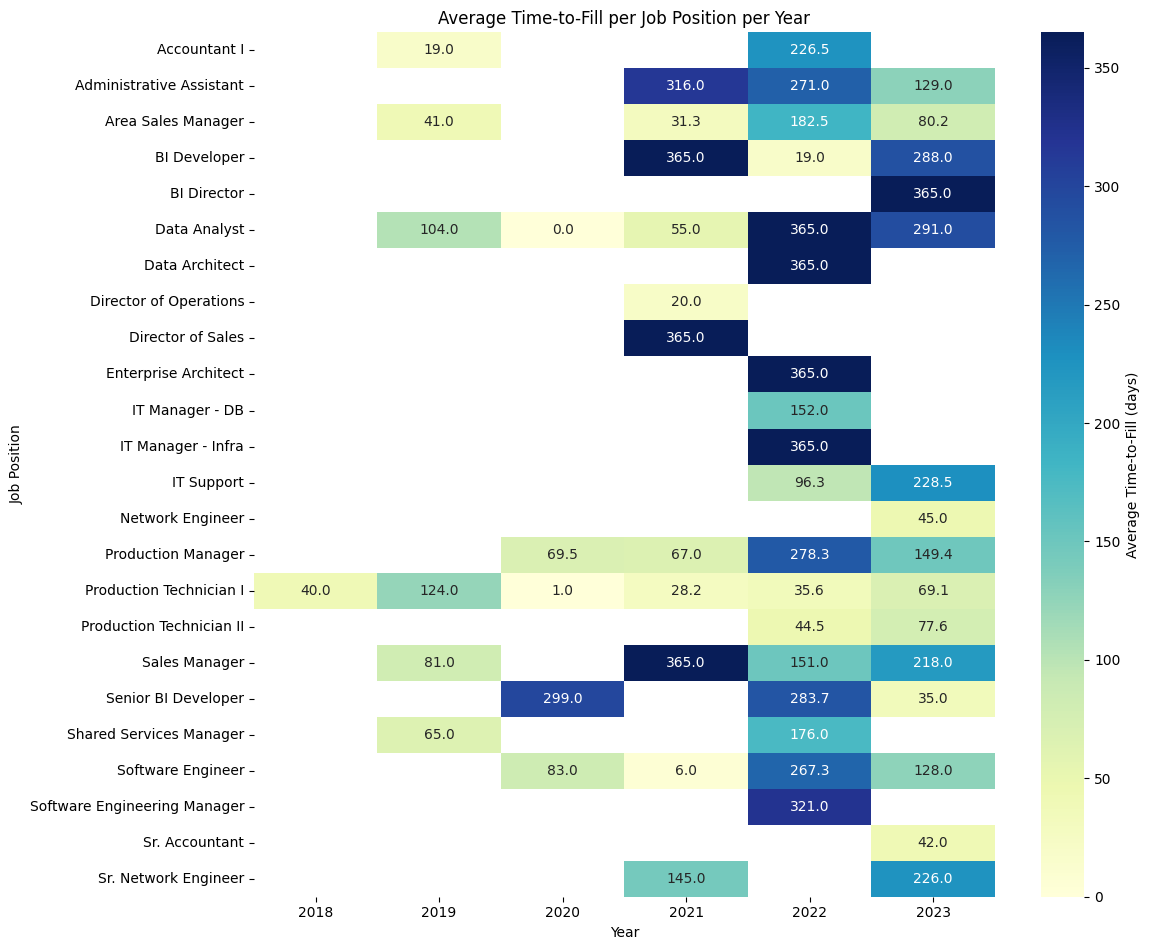

In [35]:
"""
Using heatmap, we can see that 'Data Analyst' position has high time-to-fill in 2021 and 2022.
It is also the position with high vacancy rate as we saw earlier.
This suggests that the company may have difficulty filling Data Analyst positions, 
leading to longer vacancies.
"""


# Pivot
time_to_fill_hm = time_to_fill_summary.pivot_table(
    index='Title', 
    columns='Year', 
    values='TimeToFillCapped', 
    aggfunc='mean'
)

plt.figure(figsize=(12, len(time_to_fill_hm)*0.4))
sns.heatmap(
    time_to_fill_hm, 
    annot=True,          
    fmt=".1f",           
    cmap="YlGnBu",       
    cbar_kws={'label': 'Average Time-to-Fill (days)'}
)

plt.title("Average Time-to-Fill per Job Position per Year")
plt.xlabel("Year")
plt.ylabel("Job Position")
plt.tight_layout()
plt.show()


### Quality of Hire

**Quality of Hire** measures how effective the hiring process is by looking at how well new employees perform after joining. In this dataset, I define a successful hire as an employee whose PerformanceScore is either “Fully Meets” or “Exceeds” expectations.

$$
Quality of Hire (\%) = \frac{Number of successful new hires in a year}{Total number of new hires in the same year} * 100
$$

* Successful new hires: number of employees who joined in a given year and achieved a performance score of “Fully Meets” or “Exceeds”.
* Total new hires: all employees who started in the same year.

The calculation is done separately for each job position and for each year. For every position, new hires are grouped by their start year, and the code counts how many meet or exceed performance expectations. This number is divided by the total hires in the same year and multiplied by 100 to express it as a percentage. 

A higher percentage indicates that the recruitment process is successfully attracting employees who perform well and contribute positively to the organization.

In [36]:
# First, define 'Quality' based on performance rating
successful_scores = ["Fully Meets", "Exceeds"]

In [37]:
# Next, get year start of each employee
talent_acq_df['StartYear'] = talent_acq_df['StartDate'].dt.year
talent_acq_df.head()

,EmpID,FirstName,LastName,StartDate,ExitDate,Title,Supervisor,ADEmail,BusinessUnit,EmployeeType,...,RaceDesc,MaritalDesc,PerformanceScore,CurrentEmployeeRating,ExitYear,CleanedEmployeeStatus,Year,PrevExit,TimeToFillDays,StartYear
915,1342,Jeffery,Hogan,2019-06-22,2019-08-26,Accountant I,Mark Willis,jeffery.hogan@bilearner.com,EW,Full-Time,...,Asian,Single,Fully Meets,3,2019.0,Inactive,2019,NaT,NaN,2019
945,1372,Frankie,Davenport,2022-11-24,2025-12-31,Accountant I,Gary Clark,frankie.davenport@bilearner.com,MSC,Contract,...,White,Single,Exceeds,3,NaN,Active,2022,2019-08-26,1186.0,2022
2173,2600,Thomas,Sloan,2018-09-18,2025-12-31,Administrative Assistant,Kelsey Dunn,thomas.sloan@bilearner.com,CCDR,Full-Time,...,Asian,Widowed,Fully Meets,2,NaN,Active,2018,NaT,NaN,2018
942,1369,Shea,Novak,2021-03-26,2025-12-31,Administrative Assistant,Darren Zimmerman,shea.novak@bilearner.com,CCDR,Contract,...,Black,Married,Exceeds,3,NaN,Active,2021,2025-12-31,-1741.0,2021
896,1323,Leigh Ann,Smith,2022-12-06,2025-12-31,Administrative Assistant,Mary Walker,leigh ann.smith@bilearner.com,PL,Full-Time,...,Black,Divorced,Fully Meets,3,NaN,Active,2022,2025-12-31,-1121.0,2022


In [38]:
# Flag successful hires
talent_acq_df['SuccessfulHire'] = talent_acq_df['PerformanceScore'].isin(successful_scores)
talent_acq_df.head()

,EmpID,FirstName,LastName,StartDate,ExitDate,Title,Supervisor,ADEmail,BusinessUnit,EmployeeType,...,MaritalDesc,PerformanceScore,CurrentEmployeeRating,ExitYear,CleanedEmployeeStatus,Year,PrevExit,TimeToFillDays,StartYear,SuccessfulHire
915,1342,Jeffery,Hogan,2019-06-22,2019-08-26,Accountant I,Mark Willis,jeffery.hogan@bilearner.com,EW,Full-Time,...,Single,Fully Meets,3,2019.0,Inactive,2019,NaT,NaN,2019,True
945,1372,Frankie,Davenport,2022-11-24,2025-12-31,Accountant I,Gary Clark,frankie.davenport@bilearner.com,MSC,Contract,...,Single,Exceeds,3,NaN,Active,2022,2019-08-26,1186.0,2022,True
2173,2600,Thomas,Sloan,2018-09-18,2025-12-31,Administrative Assistant,Kelsey Dunn,thomas.sloan@bilearner.com,CCDR,Full-Time,...,Widowed,Fully Meets,2,NaN,Active,2018,NaT,NaN,2018,True
942,1369,Shea,Novak,2021-03-26,2025-12-31,Administrative Assistant,Darren Zimmerman,shea.novak@bilearner.com,CCDR,Contract,...,Married,Exceeds,3,NaN,Active,2021,2025-12-31,-1741.0,2021,True
896,1323,Leigh Ann,Smith,2022-12-06,2025-12-31,Administrative Assistant,Mary Walker,leigh ann.smith@bilearner.com,PL,Full-Time,...,Divorced,Fully Meets,3,NaN,Active,2022,2025-12-31,-1121.0,2022,True


In [39]:
# Now, group by JobPosition and StartYear
quality_of_hire = talent_acq_df.groupby(['Title', 'StartYear']).agg(
    TotalHires=('EmpID', 'count'),
    SuccessfulHires=('SuccessfulHire', 'sum')
).reset_index()

quality_of_hire

,Title,StartYear,TotalHires,SuccessfulHires
0,Accountant I,2018,3,3
1,Accountant I,2019,11,11
2,Accountant I,2020,2,2
3,Accountant I,2021,7,6
4,Accountant I,2022,6,5
...,...,...,...,...
163,Sr. Network Engineer,2019,11,8
164,Sr. Network Engineer,2020,12,11
165,Sr. Network Engineer,2021,12,10
166,Sr. Network Engineer,2022,9,6


In [40]:
# Calculate Quality of Hire %
quality_of_hire['QualityOfHirePct'] = (quality_of_hire['SuccessfulHires'] / quality_of_hire['TotalHires']) * 100
quality_of_hire.head()

,Title,StartYear,TotalHires,SuccessfulHires,QualityOfHirePct
0,Accountant I,2018,3,3,100.000000
1,Accountant I,2019,11,11,100.000000
2,Accountant I,2020,2,2,100.000000
3,Accountant I,2021,7,6,85.714286
4,Accountant I,2022,6,5,83.333333


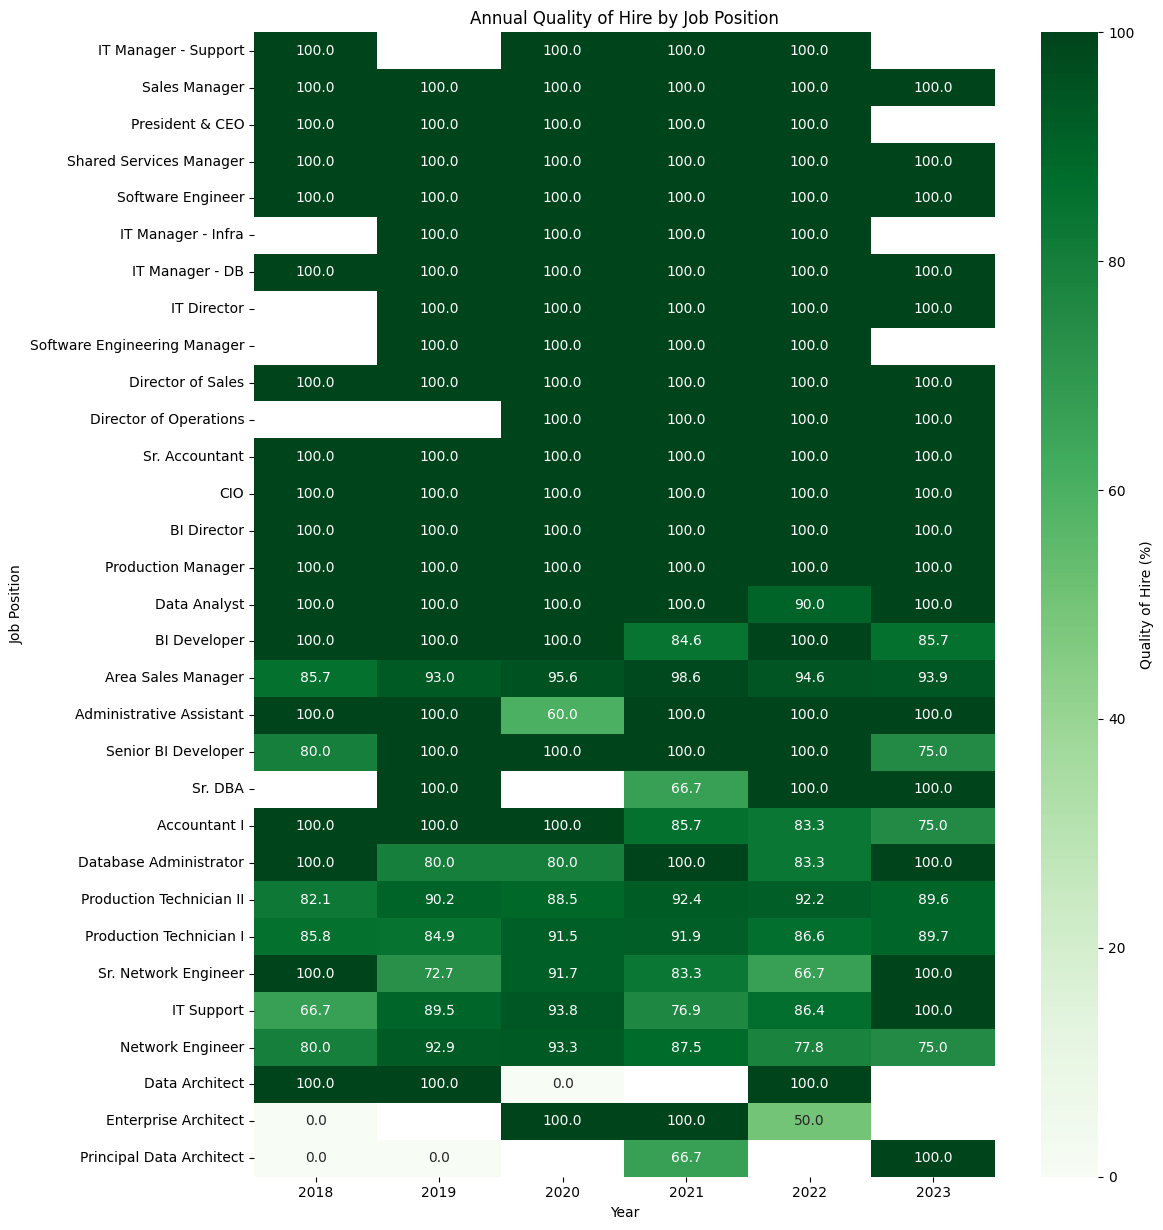

In [41]:
# Heatmap
qoh_hm = quality_of_hire.pivot(index='Title', columns='StartYear', values='QualityOfHirePct')

# Sort by overall average Quality of Hire
qoh_hm = qoh_hm.loc[qoh_hm.mean(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(12, len(qoh_hm)*0.4))
sns.heatmap(
    qoh_hm, 
    annot=True, 
    fmt=".1f", 
    cmap='Greens', 
    cbar_kws={'label': 'Quality of Hire (%)'}
)
plt.title('Annual Quality of Hire by Job Position')
plt.xlabel('Year')
plt.ylabel('Job Position')
plt.tight_layout()
plt.show()

### Hire Trend Analysis

**Hire Trend Analysis** can include a broad range of analysis such as:

* *Applicant-to-Hire Ratio* which measures selectivity by comparing the number of applicants to the number of successful hires.

* *Diversity of Hire* which measures how well the organization is attracting a workforce from different demographic groups.

* *Hiring Source Effectiveness* evaluates which recruitment channels produce the most successful hires.

It can also include all the prior analyses I have done. It is important that HR and c-suits discuss on definition and scope of each metrics. I work for public sector which has specific business rules different from private organizations. Hence, some scope and math formula needs to be adjust based on those rules.

In this section, I utilize `clean_recruitment_data` to analyze and visualize hiring trend for basic demonstration. I apply Natural Language Processing (NLP) to analyze and group job titles. First, job titles are cleaned by removing common words like “senior” or “assistant” and lemmatized using spaCy to focus on the core role. Then, Sentence Transformers are used to convert each title into a semantic vector, capturing the meaning of the job. These vectors are clustered with K-Means to group similar roles together, and cosine similarity was calculated to measure how closely each job matches others. This process helps standardize job titles, identify clusters of similar roles, and quantify job similarity for hiring and workforce analysis.

To visualize the semantic relationships between job titles, I reduced the high-dimensional embeddings to two dimensions using t-SNE. Each job title is represented as a point on a 2D scatter plot, with similar titles positioned close to each other. The points are colored by JobCluster to highlight groups of semantically related roles. Using Plotly Express, the scatter plot is interactive, allowing hover-over details to display the original job title and its cluster. This visualization makes it easy to explore patterns, identify clusters of similar positions, and understand the structure of job titles across the organization.

Also, I add basic analytics using map visualization to show diversity of applicants based on country they are from and experience with desired salary based on age groups.

#### Previous Job Title (Using NLP)

In [42]:
applicant_df = recruit_df.copy()

In [43]:
# Embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
X_embed = model.encode(applicant_df['JobTitle'].tolist())

# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_embed)
applicant_df['JobCluster'] = clusters


# Similarity
similarities = cosine_similarity(X_embed[0].reshape(1, -1), X_embed) 
similarities = similarities.flatten()

# Add to dataframe
applicant_df['JobSimilarity'] = similarities
applicant_df[['JobTitle', 'JobSimilarity']].sort_values(by='JobSimilarity', ascending=False)

# Reduce embeddings to 2D for plotting
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_tsne = tsne.fit_transform(X_embed)

# Add 2D coordinates to your DataFrame
applicant_df['TSNE-1'] = X_tsne[:,0]
applicant_df['TSNE-2'] = X_tsne[:,1]

applicant_df.head()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,ApplicantID,ApplicationDate,FirstName,LastName,Gender,DateofBirth,PhoneNumber,Email,Address,City,...,Country,EducationLevel,YearsofExperience,DesiredSalary,JobTitle,Status,JobCluster,JobSimilarity,TSNE-1,TSNE-2
0,1001,2023-06-03,Scott,Sheppard,Male,1992-08-31,421-429-7655 ext.39421,perezjanet@example.org,597 Smith Point,Hollandfort,...,NaN,High School,8,60103.21,chief technology officer,Interviewing,1,1.000000,-36.567429,6.467343
1,1002,2023-05-15,Stanley,Lewis,Male,1965-04-29,+1-451-574-5308 ext.1681,grossmark@example.com,8116 Stuart Loop,Port Margaretfurt,...,Greenland,Bachelor's Degree,17,64575.84,designer furniture,Rejected,2,0.097571,-18.538277,-163.764633
2,1003,2023-08-04,Javier,Li,Female,1973-03-10,858-901-5499,katiemaldonado@example.com,5940 Barr Villages Suite 075,Dianaland,...,China,PhD,20,39422.71,sound technician broadcasting film video,Rejected,4,0.296776,-125.091148,-65.886261
3,1004,2023-07-28,Christopher,Johnston,Other,2001-04-04,853-681-1839 ext.2010,sheila73@example.com,442 Lewis Mount,Youngfurt,...,Ghana,High School,8,51045.11,air cabin crew,Rejected,4,0.251424,46.311726,-46.217480
4,1005,2023-06-05,Melissa,Hicks,Other,1978-06-17,364-575-8478 ext.67812,emilypatterson@example.org,95961 Taylor Circles Apt. 169,East Ashleyborough,...,Solomon Islands,Master's Degree,0,52792.86,art therapist,Interviewing,3,0.235752,-27.764191,79.581009


In [44]:
# Plot (interactive)
fig = px.scatter(
    applicant_df,
    x='TSNE-1',
    y='TSNE-2',
    color='JobCluster',
    hover_data=['JobTitle', 'JobCluster'],
    title='Semantic Clusters of Job Titles',
    color_continuous_scale='Viridis'
)

fig.show()

#### Applicant by Country

In [45]:
# Applicant by country

country_counts = applicant_df['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'ApplicantCount']

# Plot map. We use choropleth as we are plotting countries. If you have lat/lon data, you can do more detailed maps.
fig = px.choropleth(
    country_counts,
    locations="Country",
    locationmode="country names",  
    color="ApplicantCount",
    color_continuous_scale="Viridis_r",
    title="Job Applicants by Country",
    hover_name="Country",
    hover_data=["ApplicantCount"]
)

fig.show()


### Experience and Salary by Age Group

In my opinion, this is not a metric per se. Hence, I would like to categorize it as descriptive analytics. It shows the average years of experience and average desired salary of applicants within defined age groups. The bar chart represents the average experience, while the line chart overlays the average desired salary. It provides insight into how experience and salary expectations vary across different age cohorts, helping HR teams understand candidate profiles, plan recruitment strategies, and benchmark compensation effectively.

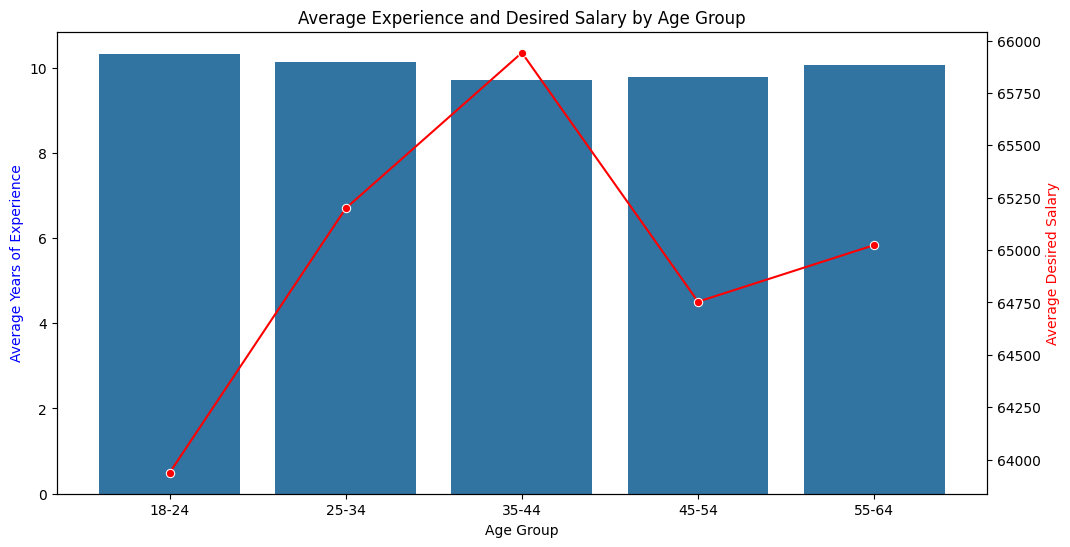

In [46]:
# Calculate age
today = pd.Timestamp.now()
recruit_df['Age'] = (today - recruit_df['DateofBirth']).dt.days // 365

# We want to look at age group so we define bins and labels
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Create age group column
recruit_df['AgeGroup'] = pd.cut(recruit_df['Age'], bins=bins, labels=labels, right=False)

# Group by age group and calculate average experience and desired salary
age_group_stats = recruit_df.groupby('AgeGroup').agg({
    'YearsofExperience':'mean',
    'DesiredSalary':'mean'
}).reset_index()


# We plot average experience and desired salary by age group using bar and line chart
fig, ax1 = plt.subplots(figsize=(12,6))

# Bar
sns.barplot(x='AgeGroup', y='YearsofExperience', data=age_group_stats, ax=ax1)
ax1.set_ylabel('Average Years of Experience', color='blue')
ax1.set_xlabel('Age Group')

# Line
ax2 = ax1.twinx()
sns.lineplot(x='AgeGroup', y='DesiredSalary', data=age_group_stats, color='red', marker='o', ax=ax2)
ax2.set_ylabel('Average Desired Salary', color='red')

plt.title('Average Experience and Desired Salary by Age Group')
plt.show()



#### Correlation between Experience and Desired Salary

We can also examine the relationship between years of experience and desired salary to understand how compensation expectations change as employees gain more experience. By calculating the correlation coefficient between these two variables, we can determine whether more experienced employees consistently expect higher salaries or if other factors play a larger role in salary expectations.

Be cautious, this analysis use correlation on all applicant demographics. It does not take into account differences in education level, previous job title, country, and etc.


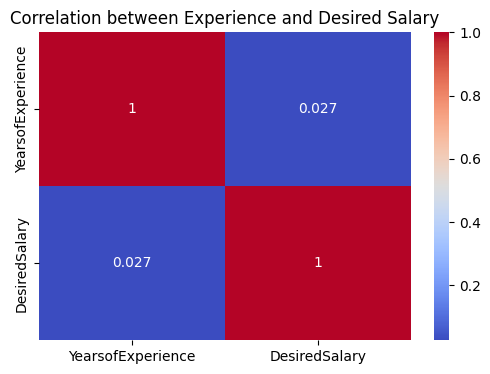

In [48]:
# Heatmap
exp_salary_cols = ['YearsofExperience', 'DesiredSalary']
plt.figure(figsize=(6,4))
sns.heatmap(applicant_df[exp_salary_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Experience and Desired Salary")
plt.show()